In [76]:
from sklearn import datasets
import cgt
import matplotlib.pyplot as plt
import numpy as np
from cgt import nn

%matplotlib inline

In [87]:
digits = datasets.load_digits()

In [88]:
digits.data

array([[  0.,   0.,   5., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,  10.,   0.,   0.],
       [  0.,   0.,   0., ...,  16.,   9.,   0.],
       ..., 
       [  0.,   0.,   1., ...,   6.,   0.,   0.],
       [  0.,   0.,   2., ...,  12.,   0.,   0.],
       [  0.,   0.,  10., ...,  12.,   1.,   0.]])

In [89]:
digits.data.shape

(1797, 64)

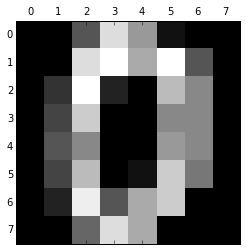

In [90]:
plt.gray()
plt.matshow(digits.images[0])

In [91]:
len(digits.target)

1797

Ok, we've had a little peek at our dataset, lets prep it for our model.

In [92]:
randinds = np.random.permutation(len(digits.target))

In [93]:
# shuffle the values
from sklearn.utils import shuffle
data, targets = shuffle(digits.data, digits.target, random_state=0)

In [101]:
# scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
data_scaled = scaler.transform(data)

In [102]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_scaled, targets, test_size=0.20, random_state=0)

In [103]:
X_train.shape, y_train.shape

((1437, 64), (1437,))

Prep is done, time for the model.

In [166]:
from cgt.distributions import categorical

def model(X, y):
    # relu(W*x + b)
    np.random.seed(0)
    h1 = nn.rectify(nn.Affine(64, 512, weight_init=nn.IIDGaussian(std=.1))(X))
    h2 = nn.rectify(nn.Affine(512, 512, weight_init=nn.IIDGaussian(std=.1))(h1))

    # softmax probabilities
    probs = nn.softmax(nn.Affine(512, 10)(h2))
    
    # our prediction is the highest probability
    ypreds = cgt.argmax(probs, axis=1)
        
    acc = cgt.cast(cgt.equal(ypreds, y), cgt.floatX).mean()
    cost = -categorical.loglik(y, probs).mean()
    
    return cost, acc

In [167]:
X = cgt.matrix(name='X', fixed_shape=(None, 64))
y = cgt.vector(name='y', dtype='i8')

cost, acc = model(X, y)

We've defined the cost and accuracy functions, time to train our model.

In [168]:
learning_rate = 1e-3
epochs = 100
batch_size = 64

# get all the weight parameters for our model
params = nn.get_parameters(cost)
# train via SGD, use 1e-3 as the learning rate
updates = nn.sgd(cost, params, learning_rate)

In [169]:
# Functions
trainf = cgt.function(inputs=[X,y], outputs=[], updates=updates)
cost_and_accf = cgt.function(inputs=[X,y], outputs=[cost,acc])

In [170]:
import time

for i in xrange(epochs):
    t1 = time.time()
    for srt in xrange(0, X_train.shape[0], batch_size):
        end = batch_size+srt
        trainf(X_train[srt:end], y_train[srt:end])
    elapsed = time.time() - t1
    costval, accval = cost_and_accf(X_test, y_test)
    print("Epoch {} took {}, test cost = {}, test accuracy = {}".format(i+1, elapsed, costval, accval))
    

Epoch 1 took 0.172019004822, test cost = 2.20501685143, test accuracy = 0.524999976158
Epoch 2 took 0.147954940796, test cost = 2.11127901077, test accuracy = 0.672222197056
Epoch 3 took 0.153834104538, test cost = 2.02107143402, test accuracy = 0.730555534363
Epoch 4 took 0.171836137772, test cost = 1.93480193615, test accuracy = 0.769444465637
Epoch 5 took 0.165919065475, test cost = 1.85273849964, test accuracy = 0.783333361149
Epoch 6 took 0.152409076691, test cost = 1.77495181561, test accuracy = 0.811111092567
Epoch 7 took 0.152605772018, test cost = 1.70139038563, test accuracy = 0.819444417953
Epoch 8 took 0.153925895691, test cost = 1.63193762302, test accuracy = 0.822222232819
Epoch 9 took 0.15299487114, test cost = 1.56644046307, test accuracy = 0.830555558205
Epoch 10 took 0.155354976654, test cost = 1.5047249794, test accuracy = 0.844444453716
Epoch 11 took 0.163406848907, test cost = 1.44660675526, test accuracy = 0.852777779102
Epoch 12 took 0.158044099808, test cost = 1